In [23]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import ale_py
from ale_py import ALEInterface
from torch import nn
ale = ALEInterface()
from PIL import Image

gym.register_envs(ale_py)

In [24]:
env = gym.make("ALE/BeamRider-v5", render_mode="rgb_array", obs_type="grayscale")


In [29]:
def convert_rgb_to_grayscale(rgb_image):
    grayscale_image = np.dot(rgb_image[..., :3], [0.2989, 0.5870, 0.1140])
    grayscale_image = np.clip(grayscale_image, 0, 255)
    grayscale_image = grayscale_image.astype(np.uint8)
    img = Image.fromarray(grayscale_image)
    img = img.resize((110, 84))
    img = img.crop((0, 18, 84, 102))
    return np.array(img)

def render_rgbarray(env):
    plt.imshow(convert_rgb_to_grayscale(env.render()))
    plt.axis('off')
    plt.show()


(210, 160, 3)


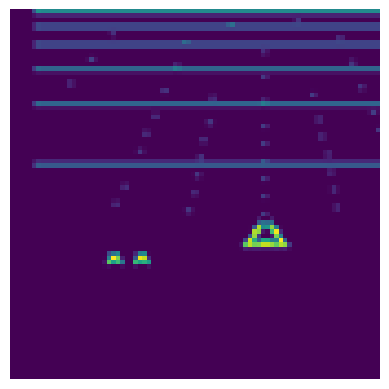

(210, 160, 3)


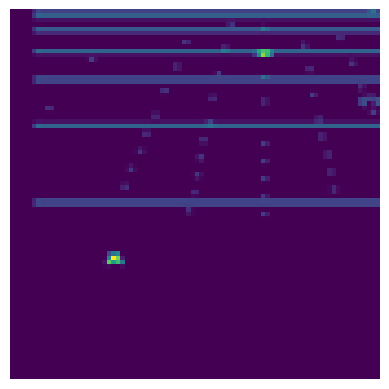

(210, 160, 3)


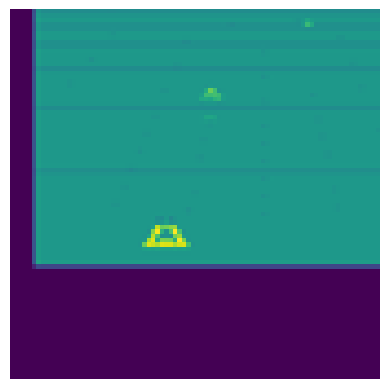

(210, 160, 3)


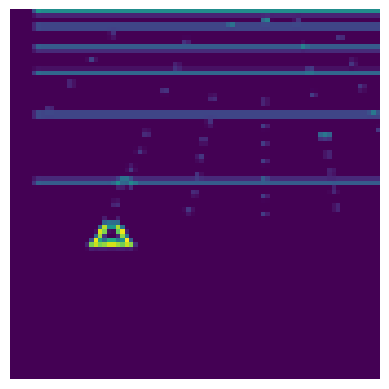

In [31]:
env.reset()
for i in range(10000):
    action = env.action_space.sample()
    observation, reward, done, info, _ = env.step(action)
    if i % 500 == 0:
        print(np.shape(env.render()))
        render_rgbarray(env)
    if done:
        break
env.close()


In [ ]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions, hidden_depth, image_stack):
        super(DQN, self).__init__()

        self.input_shape = input_shape  # input image shape
        self.num_actions = num_actions  # no. of actions
        self.hidden_depth = hidden_depth  # no. of filters in first conv layer
        self.image_stack = image_stack  # no. of previous frames to stack

        # self.replay_memory = torch.zeros((100000, image_stack, *input_shape), dtype=torch.uint8)

        self.dqn = nn.Sequential(
            nn.Conv2d(self.image_stack, hidden_depth, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(hidden_depth, hidden_depth * 2, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(hidden_depth * 2, hidden_depth * 2, kernel_size=3, stride=1),
            nn.ReLU(), 
            nn.Flatten(),
            nn.Linear(self.feature_size(), 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )

    def forward(self, x):

        return self.dqn(x)

class ReplayMemory:
    def __init__(self, capacity, image_stack, input_shape):
        self.input_shape = input_shape
        self.capacity = capacity
        self.image_stack = image_stack
        self.replay_memory = []

    def add(self, state, action, reward, next_state):
        self.replay_memory.append((state, action, reward, next_state))
        if len(self.replay_memory) >= self.capacity:
            self.replay_memory.pop(0)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.replay_memory), batch_size, replace=False)
        batch = [self.replay_memory[idx] for idx in indices]
        states, actions, rewards, next_states = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards), np.array(next_states))
    
    def __len__(self):
        return len(self.replay_memory)
    


    